Online Dictionary Learning for Change Point Detection
=====================================

Sparse approximation problem formulations
-----------------------------------------

Sparsity-constrained: $\underline{\hat{\gamma}} = \underset{\underline{\gamma}}{arg\,min}\|\underline{x} - D \underline{\gamma}\|_2^2 \quad\text{s.t.}\quad
  \|\underline{\gamma}\|_0 \leq K$
  
Error-constrained: $\underline{\hat{\gamma}} = \underset{\underline{\gamma}}{arg\,min}\|\underline{\gamma}\|_0 \quad\text{s.t.}\quad \|\underline{x} - D \underline{\gamma}\|_2^2 \leq \epsilon$

Dictionary learning
-------------------


In [32]:
import matplotlib.pyplot as plt
import scipy as sc
import numpy as np
from time import time
import math
import itertools

Data size (5664183,), frame rate 16000


In [33]:
# Load signal used to build the dictionary
from scipy.io import wavfile

# import os
# os.chdir("/path/to/wav")
# fs, data = wavfile.read("03 Shot In The Back Of The Head.wav")
fs, data = wavfile.read("BohemianRhapsody_Mono16_16khz.wav")

#print(data.dtype)

# http://samcarcagno.altervista.org/blog/basic-sound-processing-python/
# the sound pressure values are mapped to integer values that can range 
# from -2^15 to (2^15)-1. We can convert our sound array to floating point
# values ranging from -1 to 1 as follows:
data = data / 2.0**15
data_len = data.shape[0]
reconstruction = np.zeros(data_len)
print('Data size %s, frame rate %s' % (data.shape, fs))

Data size (5664183,), frame rate 16000


(10, 16000)


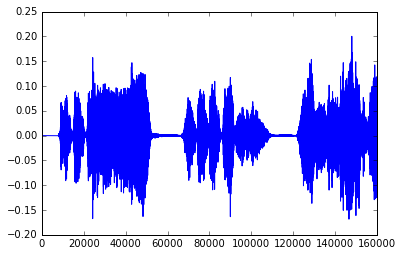

In [31]:
# Define desired training parameters
sliding_window_sec = 1
m = fs*sliding_window_sec
k = 256 #nb of atoms

# Convert training parameter to testing parameters
# Testing window will be scaled by an integer from the sliding window
test_factor = 10
end_test = m*test_factor
training_data_vec = data[0:end_test]
training_data = training_data_vec.reshape(test_factor,m)
print(training_data.shape)

#Plot training set
%matplotlib inline
plt.plot(training_data_vec)

# play training sample signal
from IPython.display import Audio
Audio(rate=fs, data=training_data_vec)

In [47]:
# Build the initial dictionary
from sklearn.decomposition import MiniBatchDictionaryLearning
t0 = time()

# by default, fit with LARS and transform with OMP
lambda_param = 1.2/math.sqrt(m) #As per Mairal suggestion, p. 6

#Mairal:
#X is n samples (iid samples from unknown distribution) in m dimensions -- (m x n)
#D is (m x k)
# k << n, k > m (overcomplete)
# So, for this signal:
#    * m is the sample audio length we choose to take
#    * n is the length of the audio signal data / m
#    * k is the num_components we choose to generate in the dictionary
#------------------------------
# Input: samples X (n_samples = test_factor, n_features = m)
# Output: dictionary D of size (n_components = k, n_features = m)

dico = MiniBatchDictionaryLearning(n_components = k, alpha = alpha, batch_size = 1)
D = dico.fit(training_data)
t1 = time() - t0
print('Trained in %d seconds' % t1)

KeyboardInterrupt: 

In [46]:
dict_D = D.components_
coder = SparseCoder(dictionary = dict_D, transform_alpha = alpha, transform_algorithm = "lasso_cd")
alpha_vector = coder.transform(new_data)
reconstruction[0:end_test] = dict_D.T * alpha_vector
#dict_A = D.inner_stats_[0]
#alpha_vector = math.sqrt(dict_A.diagonal())

DictionaryLearning(alpha=0.009486832980505138, code_init=None, dict_init=None,
          fit_algorithm='lars', max_iter=1000, n_components=256, n_jobs=1,
          random_state=None, split_sign=False, tol=1e-08,
          transform_algorithm='omp', transform_alpha=None,
          transform_n_nonzero_coefs=None, verbose=False)


In [ ]:
last_idx = end_test

while (last_idx+m) <= data_len:
    new_data = data[last_idx:last_idx+m].reshape(1,m)
    coder = SparseCoder(dictionary = dict_D, transform_alpha = alpha, transform_algorithm = "lasso_cd")
    alpha_vector = coder.transform(new_data)
    reconstruction[last_idx:last_idx+m] = dict_D.T * alpha_vector
    dico = MiniBatchDictionaryLearning(n_components = k, alpha = lambda_param, batch_size = 1, dict_init = dict_D)
    D = dico.partial_fit(new_data)
    dict_D = D.components_
    #dict_A = D.inner_stats_[0]
    #alpha_vector = math.sqrt(dict_A.diagonal())
    last_idx += m

In [ ]:
# end my work

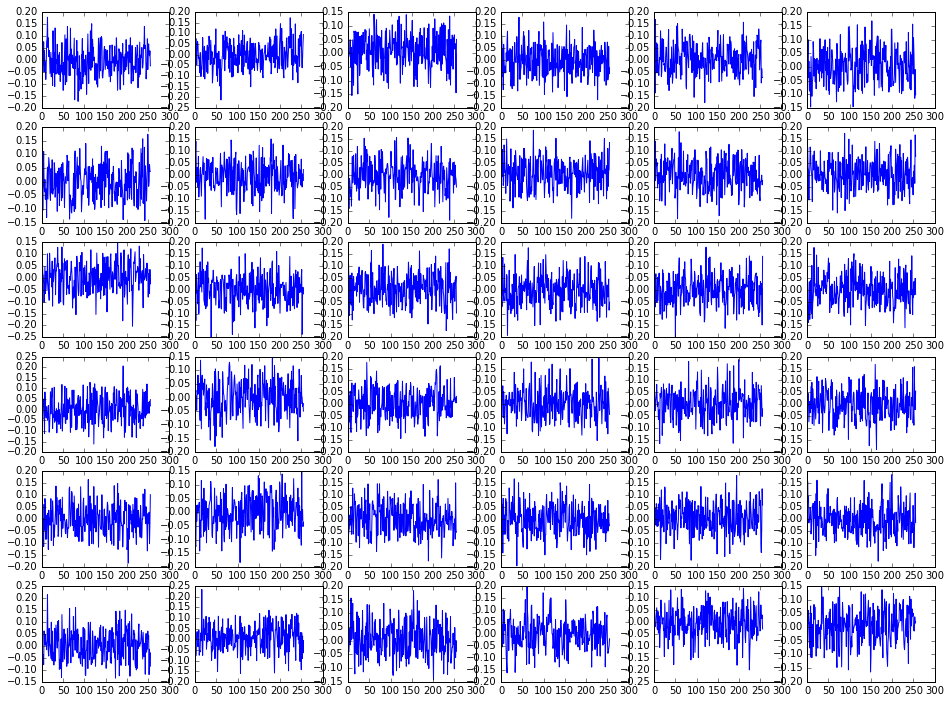

In [26]:
import itertools
# Example of an entry from the dictionary
fig, axes = plt.subplots(6,6)
fig.set_size_inches(16,12)
for i, j in itertools.product(range(1,7), range(6)):
    axes[i-1][j].plot(D[6*(i-1)+j])

In [40]:
# Get sample speech segment to reconstruct
test_data = data[fs * 11:fs*31].reshape(int(fs * 20 / 256), 256)
test_data.shape
# Reconstruct it frame-by-frame using a linear combination of 100 atoms per frame (sparsity-constrained OMP)
result = np.ndarray((test_data.shape[0],512))

from sklearn.decomposition import SparseCoder

coder = SparseCoder(dictionary = D, transform_n_nonzero_coefs = 50, 
                    transform_alpha = None, transform_algorithm = "omp")

t0 = time()
result = coder.transform(test_data)
t1 = time() - t0
print('Coded signal using OMP and learned dictionary in %d seconds.' % t1)

Coded signal using OMP and learned dictionary in 38 seconds.


In [41]:
orig = data[fs * 11:fs * 31]
out = np.zeros(orig.shape)

for n in range(result.shape[0]):
    out[n * 256:(n + 1) * 256] = np.sum(D.T * result[n],axis = 1)

In [42]:
Audio(data = out, rate = fs)

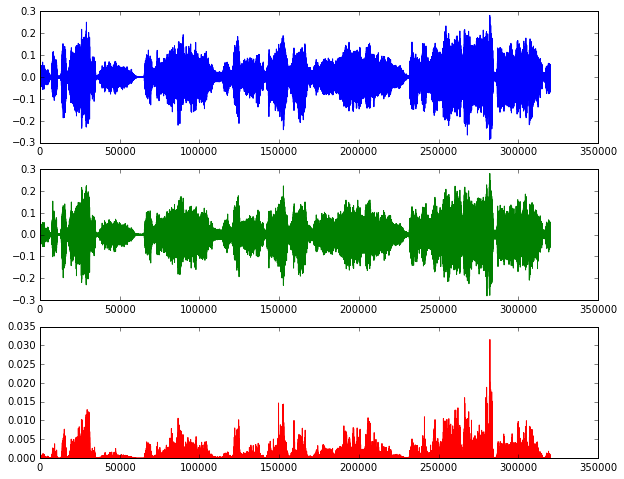

In [43]:
fig, axes = plt.subplots(3)
fig.set_size_inches(10,8)

axes[0].plot(orig)
axes[1].plot(out, 'g')
axes[2].plot((out-orig)**2, 'r')

In [83]:
wavfile.write('reconst.wav', 16000, np.asarray(out, dtype = np.float32))
wavfile.write('orig.wav', 16000, np.asarray(orig, dtype = np.float32))